In [4]:
import os
import sys
sys.path.insert(0, os.path.abspath('../'))
import numpy as np 
import torch
import torchvision
import matplotlib.pyplot as plt

import datasets.mnist as mnist
import datasets.cifar10 as cifar10
import constants
from configuration import Configuration, DEFAULT_DICT
from methods.moe.MixtureOfExperts import SimpleMoE
from methods.mcdropout.MCDropout import MCDropout
            
from util import *
import nb_util
from importlib import reload
import glob
from collections import defaultdict

In [5]:
test_loader = mnist.get_test_loader('/scratch/gp491/data', 128, corrupted=True, intensity=60, corruption='rotation')
metric_dict = {'NLL': lambda p, g: metrics.basic_cross_entropy(p, g).item(), 
                    'ECE': metrics.wrap_ece(bins=20), 
                    'Brier': metrics.wrap_brier()}

In [34]:
def get_gate_weight_cumulative(test_loader, trainer, n=5, c=0):
    gate_vals = np.zeros(n)
    count = 0
    class_vals = np.zeros(n)
    class_count = 0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.cuda(), y.cuda()
            gate_out = trainer.model.gating_network(x)
            ma, amax = gate_out.max(1)
            # max_mask = np.where(gate_out.cpu() == ma.unsqueeze(1), 1, 0)
            gate_vals += gate_out.sum(0).cpu().numpy()
            # count_max += max_mask.sum(0)
            count += x.shape[0]

            class_out = gate_out[y == c]
            class_vals += class_out.sum(0).cpu().numpy()
            class_count += class_out.shape[0]

    return gate_vals, count, class_vals, class_count

In [22]:
mnist_dir = '/scratch/gp491/wandb/checkpoints/mnist-moe'
baseline_dirs = list([f'/scratch/gp491/wandb/checkpoints/mnist_baseline_{s}' for s in [0, 10, 2137]])

mnist_res = defaultdict(list)

for d in baseline_dirs + [mnist_dir]:
    paths =  glob.glob(f'{d}/*')
    for path in paths:
        try:
            res = nb_util.MNISTRunData(path)
            mnist_res[res.name].append(res)
        except:
            pass

mnist_res_comb = {}
for key, value in mnist_res.items():
    mnist_res_comb[key] = nb_util.MNISTMultiRunData(value)

In [32]:
def plot_bars_distribution(ax, bar_heights):
    ax.bar(np.arange(bar_heights.shape[0]), bar_heights, color=nb_util.light_green)

    ax.set_ylim(0,1)

    nb_util.set_axis_props(ax, 'Expert', 'Mean Weight Assigned', 15)


In [24]:
mnist_res_comb.keys()

dict_keys(['lenet-ens-5', 'lenet-mcdrop-50', 'lenet-single', 'sum-loss-gate-conv', 'ens-loss-gate-conv', 'sum-loss-gate-same', 'ens-loss-gate-same', 'sum-loss-gate-simple', 'ens-loss-gate-simple', 'sum-loss-gate-mcd_conv-0.1', 'ens-loss-gate-mcd_conv-0.1', 'sum-loss-gate-mcd_conv-0.5', 'ens-loss-gate-mcd_conv-0.5', 'sum-loss-gate-mcd_conv-0.9', 'ens-loss-gate-mcd_conv-0.9', 'sum-loss-gate-mcd_lenet-0.1', 'ens-loss-gate-mcd_lenet-0.1', 'sum-loss-gate-mcd_lenet-0.5', 'ens-loss-gate-mcd_lenet-0.5', 'sum-loss-gate-mcd_lenet-0.9', 'ens-loss-gate-mcd_lenet-0.9', 'sum-loss-gate-mcd_simple-0.1', 'ens-loss-gate-mcd_simple-0.1', 'sum-loss-gate-mcd_simple-0.5', 'ens-loss-gate-mcd_simple-0.5', 'sum-loss-gate-mcd_simple-0.9', 'ens-loss-gate-mcd_simple-0.9', 'sparse-ens-loss-gate-conv', 'sparse-ens-loss-gate-same', 'sparse-ens-loss-gate-simple'])

In [57]:
r = mnist_res_comb['ens-loss-gate-mcd_conv-0.9']

In [58]:
trainer, model_args = load_trainer('/'.join(r.runs[0].path.split('/')[-2:]), 40, device='cuda')
trainer.model.cuda();

Initialising a Mixture of Experts
criterion: <function ensemble_criterion at 0x7f41f60be1f0>
Using a simple convolutional gate


In [59]:
gv, c, cv, cc = get_gate_weight_cumulative(test_loader, trainer, n=5, c=0)

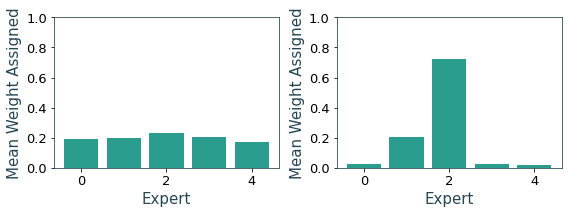

In [53]:
fig, ax = plt.subplots(1, 2, figsize=(8,3))
plot_bars_distribution(ax[0], gv/c)
plot_bars_distribution(ax[1], cv/cc)
fig.tight_layout()

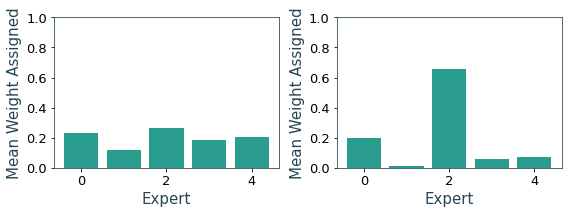

In [48]:
fig, ax = plt.subplots(1, 2, figsize=(8,3))
plot_bars_distribution(ax[0], gv/c)
plot_bars_distribution(ax[1], cv/cc)
fig.tight_layout()

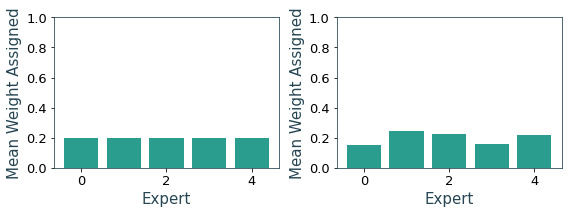

In [60]:
fig, ax = plt.subplots(1, 2, figsize=(8,3))
plot_bars_distribution(ax[0], gv/c)
plot_bars_distribution(ax[1], cv/cc)
fig.tight_layout()